# Texts, with love?

 > - (c) 2020 Porfirio Quintero. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).  
 All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

My girlfriend Ellen and I have been together for about eight months. 
During that time, we have been texting over Apple's Messages app. 
A fair amount. I am curious about the story these texts might convey, and about working with text data, especially my own.

Can we infer our moods from these data? Are there patterns related to infatuation? Arguments? Trip planning?

I will explore our text history here.

In [25]:
# Essentials
import numpy as np
import pandas as pd
import re
import datetime
import glob

# For parallel computation, because why wait
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# For Text analysis
from nltk import tokenize
from nltk.corpus import stopwords
from textblob import TextBlob

# Plots
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Wordcloud plots
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# matplotlib style
import matplotlib as mpl
rc= {'axes.edgecolor': '0.3', 'axes.labelcolor': '0.3', 'text.color':'0.3',
    'axes.spines.top': 'False','axes.spines.right': 'False',
    'xtick.color': '0.3', 'ytick.color': '0.3', 'font.size':'20',
    'savefig.bbox':'tight', 'savefig.transparent':'True', 'savefig.dpi':'500'}
for param in rc:
    mpl.rcParams[param] = rc[param]

## Get dat data

After unsuccesfully looking up on stack-overflow how to cleanly get text message data out of Apple's Messages, I concluded this was an impossible task. 

The quickest dirty way I found to extract the data is to scroll all the way up in my computer, export as pdf, and then copy-paste into a text file.  
The pdf looks like this:

<img src="../data/ellen_convo_PDF_snapshot.png" alt="snap" width="500"/>

Of course, I asked her for her number and texted her for the first time, right after which I made my first bad joke. But she kept replying so I'll stay focused.

It seems hard to extract authorship information from this PDF. Instead, selecting all the text (ctrl+A) directly from the app and copy-pasting yields this:

<img src="../data/ellen_convo_TXT_snapshot.png" alt="snap" width="500"/>

I have now two text files with the same texts but complementing metadata; the first contains date and time, the second the sender's name. Seems good enough to get started.

## Data extraction

There are two types of lines in the above text files: text messages and metadata. The metadata can be either author or date and time.

I think a useful format to explore the data is to have the text message together with author, date and time.

I will arrange the data in that format with the function below, which splits a text file in lines, iterates through them, gets the available metadata, and assigns it to the text message.

In [2]:
def convo2df(path):
    """
    Get conversation string into dataframe with metadata
    path: str
        path to text file with conversation, copy paste from messages app
    """
    
    # load file into string
    with open(path) as f: convo = f.read()
    
    # split into lines, separated by linebreaks '\n'
    lines = convo.split('\n')
    # DataFrame to store data
    text_df = pd.DataFrame()

    for l in tqdm(lines):

        try:
            # check if line is time and date
            time = re.search(r'(\d+:\d\d [A|P]M)', l).group(1)
            date = re.search(r'(\d+/\d+/\d+)', l).group(1)
            # convert to datetime format
            datetime = pd.to_datetime(date+' '+time)
            continue

        except AttributeError:

            # get author if available
            if 'Porfirio Cadena' in l:
                author='Porfi'
                continue
            elif phone_number in l:
                author='Ellen'
                continue
            # if not datetime or author, it's a text
            else: text = l.strip()

        # store in dataframe
        _df = pd.DataFrame()
        _df['text'] = [text]

        # add available metadata
        try: _df['author'] = author
        except NameError: pass

        try: _df['datetime'] = datetime
        except NameError: pass

        # store
        text_df = text_df.append(_df, ignore_index=True)

    return text_df

It takes a few minutes to scroll all the way up in the Messages app. I've done this process once before, and will probably repeat it in the future, so I've saved the text data in multiple text files. I will just iterate through them as well and concatenate everything after.

I'll first process the text from PDF files:

In [3]:
# get conversation data
convo_date = Parallel(n_jobs=12)(delayed(convo2df)(p) for p in glob.glob('../data/*frompdf.txt'))
convo_date = pd.concat(convo_date, ignore_index=False, sort='False')
# authorship is not relevant here
convo_date = convo_date.drop('author', axis=1)

This is how it looks:

In [4]:
convo_date.sort_values('datetime').head()

,datetime,text
0,2019-05-18 16:44:00,Hey Ellen its Porfi
27,2019-05-18 16:44:00,I took a friend that is just getting into it t...
28,2019-05-18 16:44:00,"Itʼs just the inconvenience and cost though, o..."
29,2019-05-18 16:44:00,Ahh
30,2019-05-18 16:44:00,Slanted is hard


Now do the same for direct copy-paste text, merge to get a dataframe with the complete metadata, and drop the duplicates arising from having multiple text files and getting metadata from two types of dataframe.

In [5]:
convo_txt = Parallel(n_jobs=12)(delayed(convo2df)(p) for p in glob.glob('../data/*txt') if 'pdf' not in p)
convo_txt = pd.concat(convo_txt, ignore_index=False, sort='False')
convo_df = pd.merge(convo_txt, convo_date, on='text')
# drop duplicates that originate from merging info from pdf and with old dfs
convo_df = convo_df.drop_duplicates(['text','datetime','author'])

In [51]:
convo_df.head()

,author,text,datetime
0,Porfi,Hey Ellen its Porfi,2019-05-18 16:44:00
1,Porfi,So did you learn any new developments in batte...,2019-05-18 16:44:00
2,Ellen,Today? Not really,2019-05-18 16:44:00
3,Porfi,"It was a bad joke, how was target",2019-05-18 16:44:00
4,Porfi,Any plans for the rest of the weekend?,2019-05-18 16:44:00


## Cleanup

It would be useful to extract the list of words from each text, for analysis and further cleanup (e.g. correcting typos).

In [7]:
def token_text(text):
    """
    Tokenize and cleanup text
    """
    # split into words using NLTK's word tokenizer
    words = tokenize.word_tokenize(text)
    # convert to lowercase and remove punctuation signs 
    words = [w.lower() for w in words if w.isalpha()]
    return words

The current data format allows me to easily apply a function like the one above:

In [8]:
convo_df['words'] = convo_df.text.apply(token_text)
convo_df.head()

,author,text,datetime,words
0,Porfi,Hey Ellen its Porfi,2019-05-18 16:44:00,"[hey, ellen, its, porfi]"
1,Porfi,So did you learn any new developments in batte...,2019-05-18 16:44:00,"[so, did, you, learn, any, new, developments, ..."
2,Ellen,Today? Not really,2019-05-18 16:44:00,"[today, not, really]"
3,Porfi,"It was a bad joke, how was target",2019-05-18 16:44:00,"[it, was, a, bad, joke, how, was, target]"
4,Porfi,Any plans for the rest of the weekend?,2019-05-18 16:44:00,"[any, plans, for, the, rest, of, the, weekend]"


There's a lot more cleanup I could do on this data. I'll keep in mind any exploration is preliminary (e.g. typos might confuse output), but I'll jump to the fun part for now.

## WordClouds



Let's make some wordclouds.

In [26]:
def plot_wordcloud(words, ax=None, title=''):
    """Convenient function to generate and plot wordcloud from list of words"""
    if ax is None: fig, ax = plt.subplots()
    # Generate wordcloud and plot
    wordcloud = WordCloud(background_color='white').generate(' '.join(words))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()
    ax.set_title(title)
    return ax, wordcloud

I wonder what do all of our collective texts look like? It's pretty easy to get the full list of all words from the dataframe.

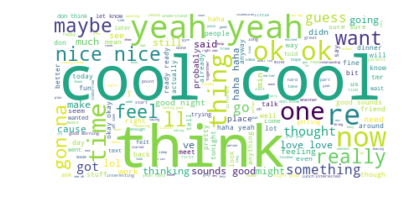

In [27]:
plot_wordcloud(convo_df.words.sum());

Interesting. How about my words and Ellen's, separately.

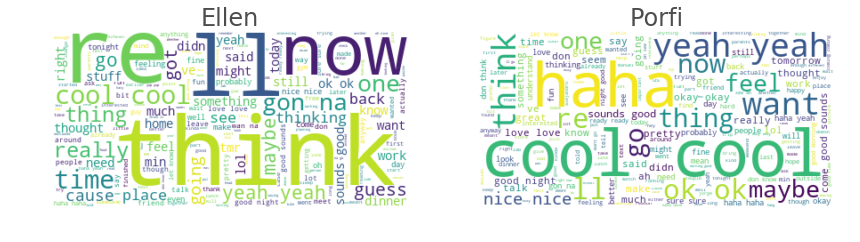

In [28]:
# Generate wordclouds by author and plot
fig, axes = plt.subplots(1,2, figsize=(14, 4))
[plot_wordcloud(convo_df.groupby('author').words.sum()[author], ax=ax, title=author)\
     for ax, author in zip(axes, ('Ellen','Porfi'))];

Some cleanup is clearly needed, e.g. the strings `re` and `ll` come from contractions like `you're` and `I'll`, but I find these plots interesting nevertheless.

## By the numbers

Who's texted more I wonder? How about by week?

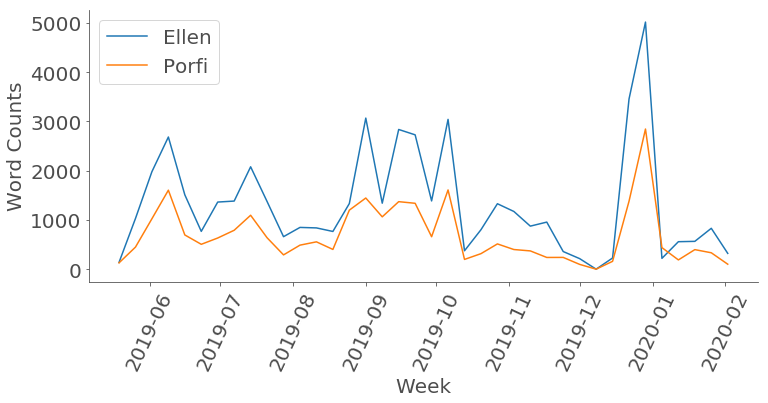

In [29]:
# count number of words by text
convo_df['wordcount'] = convo_df.words.apply(len)
# sum over weekly periods
week_summ = convo_df.groupby('author').resample('W', on='datetime').sum().reset_index()
# plot
fig, ax = plt.subplots(figsize=(12,5))
week_summ.groupby('author').apply(lambda x: ax.plot(x.datetime, x.wordcount, label=x.name))
ax.set(ylabel='Word Counts', xlabel='Week')
plt.xticks(rotation=65)
plt.legend();

Makes sense that we track each other but it's interesting to observe. What about average text length?

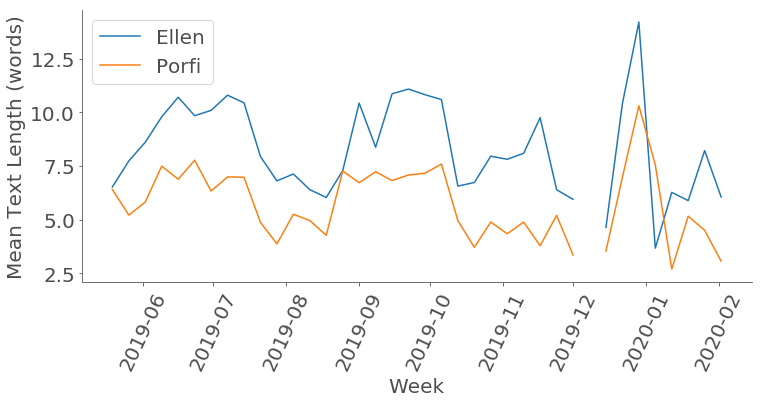

In [40]:
# average over weekly periods
week_summ = convo_df.groupby('author').resample('W', on='datetime').mean().reset_index()
# plot
fig, ax = plt.subplots(figsize=(12,5))
week_summ.groupby('author').apply(lambda x: ax.plot(x.datetime, x.wordcount, label=x.name))
ax.set(ylabel='Mean Text Length (words)', xlabel='Week')
plt.xticks(rotation=65)
plt.legend();

This is reminiscent of periods of excitement throughout our relationship. But let's not overinterpret for now.
 
While we have this, I wonder what the sizes of our vocabularies are here. Ellen is a native English speaker, I'm not. I might not fare particularly well here but let's see. Perhaps it's also good to take number of written texts into account, since Ellen has texted more, to get a sense of vocabulary diversity in texts.

In [41]:
# sum list of words by author, convert to set and count number of unique words 
wordsbyauthor = convo_df.groupby('author').words.sum()
total_wordsbyauthor = wordsbyauthor.apply(lambda x: len(x))
unique_wordsbyauthor = wordsbyauthor.apply(lambda x: len(set(x)))
ratio_wordsbyauthor = unique_wordsbyauthor / total_wordsbyauthor

print("""
Total Words Texted\n{}\n
Total Unique Words\n{}\n
Vocabulary Diversity (Unique/Total)\n{}
""".format(total_wordsbyauthor, unique_wordsbyauthor, ratio_wordsbyauthor))


Total Words Texted
author
Ellen    50426
Porfi    26190
Name: words, dtype: int64

Total Unique Words
author
Ellen    4310
Porfi    2647
Name: words, dtype: int64

Vocabulary Diversity (Unique/Total)
author
Ellen    0.085472
Porfi    0.101069
Name: words, dtype: float64



Cool cool, it's not too bad. I wonder what words does Ellen say that I don't?

I'll first get the list of words of each author, then filter out the overlap.

In [46]:
# Get sets of unique words by author
ellenwords, mywords = convo_df.groupby('author').words.sum()
# filter out overlap
ellenwords = [w for w in tqdm(ellenwords) if w not in set(mywords)]
mywords = [w for w in tqdm(mywords) if w not in set(ellenwords)]

Now I can make the wordcloud

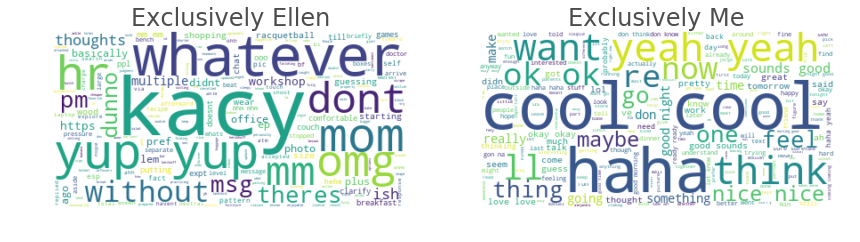

In [47]:
# Generate wordclouds of exclusive vocabularies by author and plot
fig, axes = plt.subplots(1,2, figsize=(14, 4))
plot_wordcloud(ellenwords, ax=axes[0], title='Exclusively Ellen')
plot_wordcloud(mywords, ax=axes[1], title='Exclusively Me');

## Sentiment analysis

For a quick analysis, [Textblob](https://textblob.readthedocs.io/en/dev/) has a function to compute polarity, a score in the range [-1,1] where -1 means a negative and 1 a positive sentiment, and subjectivity with a score in [0,1], where 1 means subjective. 

Let's compute those scores by text message.

In [33]:
# compute polarity and subjectivity on each text message
convo_df[['polarity','subjectivity']] = convo_df.words.apply(lambda x:\
                                    pd.Series(TextBlob(' '.join(x)).sentiment))

What words are rated as positive, negative, or subjective?

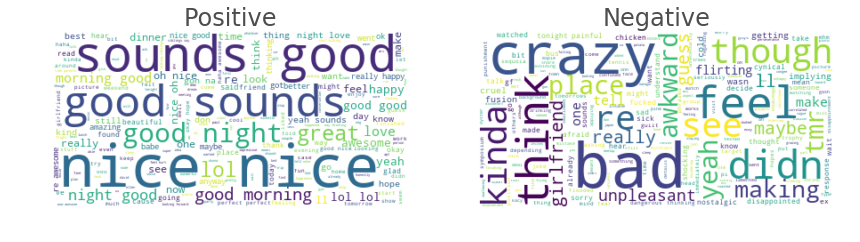

In [34]:
fig, axes = plt.subplots(1,2, figsize=(14, 4))
plot_wordcloud(convo_df.loc[convo_df.polarity>0.5].words.sum(), ax=axes[0], title='Positive')
plot_wordcloud(convo_df.loc[convo_df.polarity<-0.5].words.sum(), ax=axes[1], title='Negative');

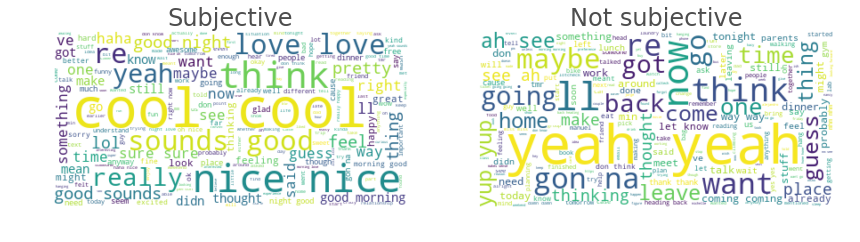

In [35]:
fig, axes = plt.subplots(1,2, figsize=(14, 4))
plot_wordcloud(convo_df.loc[convo_df.subjectivity>0.5].words.sum(), ax=axes[0], title='Subjective')
plot_wordcloud(convo_df.loc[convo_df.subjectivity<0.01].words.sum(), ax=axes[1], title='Not subjective');

I wonder if any of the features I already have are correlated, let's take a quick glance.

In [36]:
convo_df.corr()

,wordcount,polarity,subjectivity
wordcount,1.000000,-0.044978,0.188462
polarity,-0.044978,1.000000,0.633065
subjectivity,0.188462,0.633065,1.000000


I wonder what our overall distribution looks like from this perspective. I like [ECDFs](https://en.wikipedia.org/wiki/Empirical_distribution_function), I'll look through this lens.

In [37]:
def ecdf(data):
    """
    Computes the x and y values for an ECDF of a one-dimensional data set.
    """
    # Get x and y values for data points
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    return x, y

Let's take a look by user.

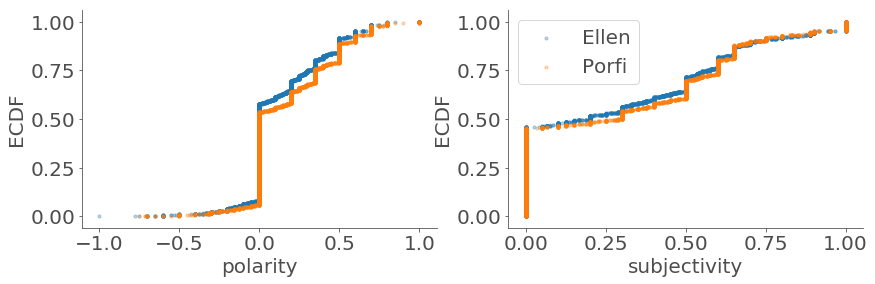

In [38]:
fig, axes = plt.subplots(1,2, figsize=(14, 4))
[convo_df.groupby('author').apply(\
    lambda x: axes[i].scatter(*ecdf(x[val].values), label=x.name, alpha=0.3, s=10))
    for i, val in enumerate(('polarity','subjectivity'))]
[axes[i].set(ylabel='ECDF', xlabel=val) for i, val in enumerate(('polarity','subjectivity'))]
plt.legend();

A good amount of neutral texts, very few negative ones. Nice that we seem fairly positive. Apparently some very objective texts too.
Maybe interesting that we have pretty similar distributions of these scores.

I wonder what this looks like over time.

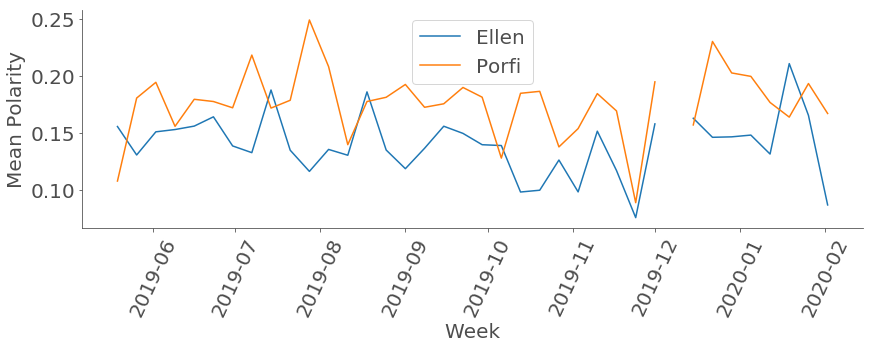

In [39]:
# get weekly summary
week_summ = convo_df.groupby('author').resample('w', on='datetime').apply(np.nanmean).reset_index()
# plot
fig, ax = plt.subplots(figsize=(14,4))
week_summ.groupby('author').apply(lambda x: ax.plot(x.datetime, x.polarity, label=x.name))
ax.set(ylabel='Mean Polarity', xlabel='Week')
plt.xticks(rotation=65)
plt.legend();

Seems like I'm generally more positive. Ellen will be happy to see this.

Next I'd like to explore what features are most informative about our moods...text frequency? vocabulary? text length? I should try to recruit Ellen to help me annotate the data. 
It would also be really interesting to have data of more couples and friends to explore and compare patterns.